# Replicating the Results of Dey *et al.* 2014
This notebook describes the creation of machine learning models for the band gaps for chalcopyrite compounds, following the paper by [Dey *et al.* (2014)](http://dx.doi.org/10.1016/j.commatsci.2013.10.016). In particular, recreates the hyper-parameter tuning, model evaluation, and feature selection reported in this work.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import itertools
import pandas as pd
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, LeaveOneOut
from sklearn import metrics

%matplotlib inline

## Load Training Data

The data for this notebook was extracted from Tables 1 and 2 from the original paper. These are stored as `csv` files in the same directory as this notebook, for convenience.

### Load element data file into a Pandas Dataframe
`element_data.csv` contains elemental properties for the all possible elements in the search space, which was provided in Table 1 of the paper.

Specifically, this file contains:
- EN: Electronegativity
- AN: Atomic Number
- MP: Melting point (K)
- PR: Pseudopotential radius (as defined by [Suh and Rajan (2004)](http://www.sciencedirect.com/science/article/pii/S0169433203009188?via%3Dihub))
- VL: Valency (as defined by as given by [Suh and Rajan (2004)](http://www.sciencedirect.com/science/article/pii/S0169433203009188?via%3Dihub))

In [2]:
#Load input data into dictionary
elem_data = pd.read_csv("datasets/dey_element_data.csv")
elem_properties = elem_data.set_index("#ELM").T.to_dict("list")
print 'Elements in lookup tables:', ' '.join(sorted(elem_properties.keys()))

Elements in lookup tables: Ag Al As Cd Cu Ga Ge In P S Se Si Sn Te Zn


### Load training data
`training_set.csv` contains experimentally determined band gap values for each compound.

In [3]:
training_file = "datasets/dey_training_set.csv"
training_set = pd.read_csv("datasets/dey_training_set.csv")
training_set.columns=["composition", "band_gap"]
training_set

,composition,band_gap
0,CuAlS2,3.49
1,CuAlSe2,2.67
2,CuAlTe2,2.06
3,CuGaS2,2.43
4,CuGaSe2,1.68
5,CuGaTe2,1.12
6,CuInS2,1.53
7,CuInSe2,1.04
8,CuInTe2,1.06
9,AgAlS2,3.13


## Compute Attributes
Attributes are what serve as input in to the machine learning model. In this section, we compute attributes given the composition of the materials.

All of the compounds in the training set are $ABC_2$ compounds where $A$ are Cu-group elements, Zn-group elements, Be, or Mg; $B$ are Group III or IV elements, and $C$ are Group VI or V elements.

Following Dey *et al.*, we compute features based on the elemental properties of the $A$, $B$, and $C$ elements using all available elemental properties

In [4]:
attributes = np.zeros((len(training_set), 15))

elem_re = re.compile('[A-Z][a-z]?')

# Compute the features
for i in range(len(training_set)):
    elements = elem_re.findall(training_set["composition"][i])
    for j in range(len(elements)):
        attributes[i,5*j:5*(j+1)] = elem_properties[elements[j]]

# Add them to dataframe
attr_labels = ["EN", "AN", "MP", "PR", "VL"]
atom_labels = ["A", "B", "C"]

labels = []
for i in range(len(atom_labels)):
    for j in range(len(attr_labels)):
        labels.append("%s_%s"%(attr_labels[j], atom_labels[i]))

training_set = training_set.assign(
    **dict(zip(labels, [attributes[:, i] for i in range(np.shape(attributes)[1])])))

training_set

,composition,band_gap,AN_A,AN_B,AN_C,EN_A,EN_B,EN_C,MP_A,MP_B,MP_C,PR_A,PR_B,PR_C,VL_A,VL_B,VL_C
0,CuAlS2,3.49,29.0,13.0,16.0,1.08,1.64,2.65,1358.0,933.5,388.4,2.040,1.675,1.100,11.0,3.0,6.0
1,CuAlSe2,2.67,29.0,13.0,34.0,1.08,1.64,2.54,1358.0,933.5,494.0,2.040,1.675,1.285,11.0,3.0,6.0
2,CuAlTe2,2.06,29.0,13.0,52.0,1.08,1.64,2.38,1358.0,933.5,722.7,2.040,1.675,1.670,11.0,3.0,6.0
3,CuGaS2,2.43,29.0,31.0,16.0,1.08,1.70,2.65,1358.0,302.9,388.4,2.040,1.695,1.100,11.0,3.0,6.0
4,CuGaSe2,1.68,29.0,31.0,34.0,1.08,1.70,2.54,1358.0,302.9,494.0,2.040,1.695,1.285,11.0,3.0,6.0
5,CuGaTe2,1.12,29.0,31.0,52.0,1.08,1.70,2.38,1358.0,302.9,722.7,2.040,1.695,1.670,11.0,3.0,6.0
6,CuInS2,1.53,29.0,49.0,16.0,1.08,1.63,2.65,1358.0,429.8,388.4,2.040,2.050,1.100,11.0,3.0,6.0
7,CuInSe2,1.04,29.0,49.0,34.0,1.08,1.63,2.54,1358.0,429.8,494.0,2.040,2.050,1.285,11.0,3.0,6.0
8,CuInTe2,1.06,29.0,49.0,52.0,1.08,1.63,2.38,1358.0,429.8,722.7,2.040,2.050,1.670,11.0,3.0,6.0
9,AgAlS2,3.13,47.0,13.0,16.0,1.07,1.64,2.65,1235.0,933.5,388.4,2.375,1.675,1.100,11.0,3.0,6.0


## Feature Subset Selection
Here, we use the subset selection technique employed by Dey *et al.* to determine which group of features, out of all 15 used to describe our training set, lead to the most predictive linear model.

In [5]:
max_size = len(labels) if True else 7 # Set to True to run all combinations

In [6]:
all_subsets = sum([list(itertools.combinations(labels, s)) for s in range(1, max_size+1)], [])
print 'Number of possible subsets:', len(all_subsets)

Number of possible subsets: 32767


Run a leave-on-out cross-validation test on every subset of attributes. We use Ordinary Least Squares, but it should work with any of the regression methods.

In [7]:
def cross_validate(training_set, model, labels=labels):
    """Compute the mean squared error for a leave-one-out cross-validation test
    
    Args: training_set (DataFrame) - Data used for cr"""
    errors = cross_val_score(model, training_set[labels], training_set['band_gap'], n_jobs=1,
                             scoring='neg_mean_squared_error', cv=LeaveOneOut())
    mscve = np.mean(np.abs(errors))
    return mscve

In [8]:
#Test every subset of a given size
def test_subset(training_set, subset, method=LinearRegression()):
    """Test out a certain subset of attributes
    
    Args: training_set - Data used for fitting
          subset - Subset of attributes to use as inputs

    Returns: Mean squared error in LOOCV"""

    #Crossvalidate
    return cross_validate(training_set, method, list(subset))

In [9]:
mscve = []
for i,subset in enumerate(all_subsets):
    print "\r %d/%d - %s"%(i+1, len(all_subsets), ','.join(subset)),
    mscve.append(test_subset(training_set, subset))

 32767/32767 - EN_A,AN_A,MP_A,PR_A,VL_A,EN_B,AN_B,MP_B,PR_B,VL_B,EN_C,AN_C,MP_C,PR_C,VL_C                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [11]:
attr_selection_results = pd.DataFrame({'subset':all_subsets, 'mscve':mscve})

### Plot error metrics vs number of attributes
Determine which number of descriptors leads to the best model

In [12]:
attr_selection_results['size'] = attr_selection_results['subset'].apply(lambda x: len(x))

In [13]:
attr_selection_by_size = pd.DataFrame(dict([(i, {'size': i, 'min': g['mscve'].min(), 'mean': g['mscve'].mean(), 
                                                 'Below 0.06':float(sum(g['mscve'] < 0.06)) / len(g)})
                                            for i,g in attr_selection_results.groupby('size')])).T

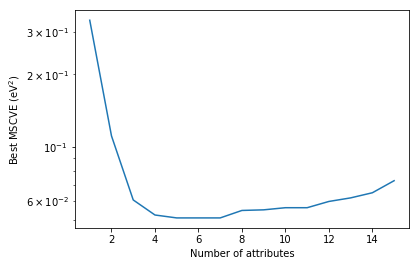

In [19]:
fig, ax = plt.subplots()

ax.semilogy(attr_selection_by_size['size'], attr_selection_by_size['min'])

ax.set_xlabel('Number of attributes')
ax.set_ylabel('Best MSCVE (eV$^2$)')

Given enough features, the model tends to overfit. Too few, and the model is underfit. The optimimum is somewhere around 5 features.

## Get the Top Attributes
Print out the top 5 (see Table 4 of Dey *et al*). Many choices of models are equivalent because there are limited numbers of chemistries (i.e., $I-III-VI_2$ and $II-IV-V_2$), which makes the valence attributes (e.g., `VL_A`) collinear. 

In [20]:
# Get nearly-equivalent models (tol=1e-8)
attr_selection_results['score'] = attr_selection_results['mscve'].apply(lambda x: int(x * 1e8))
attr_selection_results.sort_values(['score', 'size'], ascending=True, inplace=True)
attr_selection_results.drop_duplicates('score', keep='first', inplace=True)
attr_selection_results.drop('score', axis=1, inplace=True)

In [21]:
attr_selection_results['subset'] = attr_selection_results['subset'].apply(lambda x: sorted(x))

In [22]:
attr_selection_results.sort_values(['mscve', 'size'], ascending=True).head(5)

,mscve,subset,size
4596,0.051031,"[AN_B, AN_C, PR_B, PR_C, VL_A]",5
4504,0.051474,"[AN_B, AN_C, EN_B, PR_C, VL_A]",5
1669,0.052467,"[AN_B, AN_C, PR_C, VL_A]",4
4757,0.052719,"[AN_C, EN_B, MP_B, PR_B, PR_C]",5
4591,0.052871,"[AN_B, AN_C, EN_C, PR_B, VL_A]",5


In [23]:
best_subset = list(attr_selection_results.sort_values('mscve', ascending=True).iloc[0]['subset'])
print 'Best subset:', best_subset

Best subset: ['AN_B', 'AN_C', 'PR_B', 'PR_C', 'VL_A']


The features in our best subsets and the scores agree with the findings of Dey *et al* (Table 4 of their paper). The only exception is minor: our top score is `0.0510`, where the value in Table 4 is `0.0501`. Given the excellent agreement otherwise, we assume this is a typo

## Test Regression Methods
In this section, we evaluate the performance of different machine learning models. As the original code used by Dey *et al* is not available, we attempt to implement these methods using [scikit-learn](http://scikit-learn.org/stable/) where possible.

We first determine the optimal hyper-parameters for each model. e then compare their fitness on the original training set and in cross-validation.

First, we define a general fitting function. It runs a fitting procedure using the provided regression method implemented in sci-kit learn.

In [24]:
def optimize_parameters(training_set, method, labels=labels, **kwargs):
    """Determine the optimal set of parameters for an algorithm
    
    Uses leave-one-out cross-validation
    
    Args:     training_set (Dataframe): Data uses for tuning
              labels (list): Columns of training_set to use as inputs
              method (sklearn regressor): Model to be turned
    Kwargs: parameters to be tuned, and their search ranges
    Returns: Copy of the model with the parameters tuned"""
    
    return GridSearchCV(method, kwargs, cv=LeaveOneOut(), scoring='neg_mean_squared_error')\
            .fit(training_set[labels], training_set['band_gap']).best_estimator_

In [25]:
def fit_data(training_set, model, labels=labels, test_set=None):
    """ General function to fit a regression model and make a prediction.
    
        Args:    training_set (DataFrame): Inputs and outputs to the model
                 labels (list): Columns of training_set to use as inputs
                 test_set (DataFrame): Data to be evaluated (if None, run training_set)
                 model (sklearn model): Model to be tested
        Returns: updated DataFrame (ndarray)
    """

    # Fit the model
    model.fit(training_set[labels], training_set['band_gap'])
    
    # Run the prediction
    if test_set is None:
        test_set = training_set
    return model.predict(test_set[labels])

1) Ordinary Linear Regression

In [26]:
ols_model = optimize_parameters(training_set, LinearRegression(), fit_intercept=[True, False], normalize=[True, False])

In [27]:
ols_model.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'normalize': True}

In [28]:
training_set['band_gap ols'] = fit_data(training_set, ols_model)

1b) Ordinary Linear Regression, on a small subset

In [29]:
training_set['band_gap ols,selected'] = fit_data(training_set, ols_model, best_subset)

2) Lasso, implemented with LARS

In [30]:
lasso_model = optimize_parameters(training_set, LassoLars(max_iter=13), fit_intercept=[True, False],
                           alpha=np.logspace(-14,-6,11), normalize=[True, False])

C:\Users\Logan\Miniconda2\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.016e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Logan\Miniconda2\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.016e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Logan\Miniconda2\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=9.257e-04, with an active set of 7 regressors, and the smallest cholesky

C:\Users\Logan\Miniconda2\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=5.939e-04, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Logan\Miniconda2\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=5.939e-04, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Logan\Miniconda2\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=5.724e-04, with an active set of 8 regressors, and the smallest cholesky

In [31]:
lasso_model.get_params()

{'alpha': 1e-14,
 'copy_X': True,
 'eps': 2.2204460492503131e-16,
 'fit_intercept': True,
 'fit_path': True,
 'max_iter': 13,
 'normalize': True,
 'positive': False,
 'precompute': 'auto',
 'verbose': False}

In [32]:
training_set['band_gap lasso'] = fit_data(training_set, model=lasso_model)

3) Partial Least Squares Regression

In [33]:
pls_model = optimize_parameters(training_set, PLSRegression(), n_components=range(1, 10), scale=[True, False])

In [34]:
pls_model.get_params()

{'copy': True, 'max_iter': 500, 'n_components': 8, 'scale': True, 'tol': 1e-06}

In [35]:
training_set['band_gap pls'] = fit_data(training_set, pls_model)

3) Sparse Partial Least Squares

_LW 7Jul17_: The only implementation of SPLS method I found is in R ([docs](https://cran.r-project.org/web/packages/spls/spls.pdf)). Given that it has the worst performance in Dey *et al*, we elect to not test it here.

### Plot predicted vs measured results
Compare the band gaps predicted using each regression method vs. band gaps determined experimentally. See Figure 3 of Dey _et al_

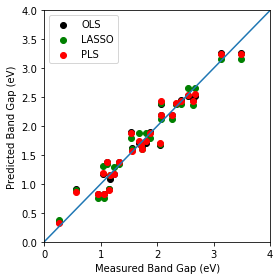

In [38]:
#band_gaps_predicted = np.zeros(np.shape(band_gaps))

plt.scatter(training_set['band_gap'], training_set['band_gap ols,selected'], color='k', label="OLS")
plt.scatter(training_set['band_gap'], training_set['band_gap lasso'], color='g', label="LASSO")
plt.scatter(training_set['band_gap'], training_set['band_gap pls'], color='r', label="PLS")

plt.legend()
plt.xlabel("Measured Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.axis([0,4,0,4])
plt.plot((0,5), (0,5))

fig = plt.gcf()
fig.set_size_inches(4, 4)

fig.tight_layout()
fig.savefig('dey-2014.png', dpi=320)

## Calculate Mean Square Cross-Validation Error

Crossvalidate all the regression methods using Leave-One-Out method

In [37]:
olss_mscve = cross_validate(training_set, ols_model, labels=best_subset)
lasso_mscve = cross_validate(training_set, lasso_model)
pls_mscve = cross_validate(training_set, pls_model)
ols_mscve = cross_validate(training_set, ols_model)

print "Mean-Squared Cross-Validation Errors \n"
print "OLS w/ best subset: %f"%olss_mscve
print "LASSO: %f"%lasso_mscve
print "PLS: %f"%pls_mscve
print "OLS w/ all features: %f"%ols_mscve

Mean-Squared Cross-Validation Errors 

OLS w/ best subset: 0.051031
LASSO: 0.059833
PLS: 0.064903
OLS w/ all features: 0.072294


While not exactly the same, our results are in general agreement with Dey. The OLS with feature selection is the best algorithm in LOOCV, followed by LASSO, and PLS. We note that our recreation is limited in that we did not use *sparse* PLS or the same LASSO implementation. Those differences in algorithm may account for the ~20% deviation in our results